In [1]:
""" Classes and examples for searching for flights using SkyPicker. """
from __future__ import unicode_literals, absolute_import, generators, \
    print_function

import requests
from datetime import datetime, timedelta
import numpy as np
import json
import pandas as pd

### for the geodesic module later on down
import os
import math
import logging
from pyproj import Geod
from shapely.geometry import LineString, mapping
from fiona import collection
from fiona.transform import transform_geom
from fiona.crs import from_epsg

### make the globe
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
class SkyPickerApi(object):
    """ SkyPicker API. """
    def __init__(self):
        """ Initializes the API object with URL attributes. """
        self.base_url = 'https://api.skypicker.com/'
        self.path = ''
        self.param_str = ''

    @property
    def full_url(self):
        """ Returns the full URL for requesting the data. """
        return '{}{}{}'.format(self.base_url, self.path, self.param_str)

    def get_request(self):
        """ Requests the API endpoint and returns the response """
        headers = {'content-type': 'application/json'}
        resp = requests.get(self.full_url, headers=headers)
        return resp.json()
    

    def search_places(self, place_name, locale=None):
        """ Finds matching place API ids to use for searches.
        :param place_name: string of the place name to search for
        :kwarg locale: two letter lowercase locale string

        returns JSON response
        """
        self.path = 'places'
        self.param_str = '?term={}'.format(place_name)
        if locale:
            self.param_str += '&locale={}'.format(locale)
        return self.get_request()
    
    def search_airports(self, iata_code, locale=None):
        """ gets lon and lat of given airport
        returns JSON response
        """
        self.path = 'locations'
        self.param_str = '?term={}'.format(iata_code)
        if locale:
            self.param_str += '&locale={}'.format(locale)
        return self.get_request()

    def search_flights(self, origin, start_date, end_date):
        """ Searches for direct flights given a time range and origin airport code.
        :param origin: string representing the ID or IATA
        :param start_date: datetime representing first possible travel date
        :param end_date: datetime representing last possible travel date

        returns JSON response
        """
        self.path = 'flights'
        self.param_str = '?flyFrom={}&dateFrom={}&dateTo={}&directFlights={}'.format(
                origin, start_date.strftime('%d/%m/%Y'),
                end_date.strftime('%d/%m/%Y'),1)

        resp = self.get_request()
        flights = []
        for flight in resp.get('data'):
            flight_info = {
                'departure': datetime.utcfromtimestamp(flight.get('dTimeUTC')),
                'arrival': datetime.utcfromtimestamp(flight.get('aTimeUTC')),
                'price': flight.get('price'),
                'currency': resp.get('currency'),
                'legs': []
            }
            flight_info['duration'] = flight_info['arrival'] - \
                flight_info['departure']
            flight_info['duration_hours'] = (flight_info[
                'duration'].total_seconds() / 60.0) / 60.0
            for route in flight['route']:
                flight_info['legs'].append({
                    'carrier': route['airline'],
                    'departure': datetime.utcfromtimestamp(
                        route.get('dTimeUTC')),
                    'arrival': datetime.utcfromtimestamp(
                        route.get('aTimeUTC')),
                    'from': '{} ({})'.format(route['cityFrom'],
                                             route['flyFrom']),
                    'to': '{} ({})'.format(route['cityTo'], route['flyTo']),
                })
            flight_info['carrier'] = ', '.join(set([c.get('carrier') for c
                                                    in flight_info['legs']]))
            flights.append(flight_info)
        return flights

In [3]:
origin = 'MUC'    #origin airport IATA code
travel_date = '07/20/2018'   
sp_api = SkyPickerApi()
sp_results = sp_api.search_flights(origin, datetime.strptime(travel_date, '%m/%d/%Y'),
                                       datetime.strptime(travel_date, '%m/%d/%Y')+timedelta(days=7))



In [4]:
dest_iata_codes = []
for i in range(len(sp_results)):
    dest_iata_code = sp_results[i]['legs'][0]['to'][-4:-1]
    dest_iata_codes.append(dest_iata_code)
    
unique_dest_iata_codes = set(dest_iata_codes)
print(unique_dest_iata_codes)

{'FMO', 'AGA', 'GOT', 'WDH', 'AGP', 'GRQ', 'MAH', 'CPH', 'SCQ', 'TRN', 'XRY', 'MAD', 'JER', 'SBZ', 'IAS', 'BHX', 'ADA', 'BKK', 'WRO', 'RUH', 'DRS', 'MXP', 'LUX', 'KGS', 'PAD', 'CWL', 'DEB', 'EFL', 'BRI', 'BEY', 'DUS', 'AOI', 'NAP', 'PRN', 'CMN', 'DOH', 'TBS', 'AOK', 'RMF', 'LEJ', 'NUE', 'LED', 'CFU', 'MBX', 'PUY', 'ALC', 'JSH', 'FCO', 'DXB', 'BRE', 'CHQ', 'BCN', 'LPA', 'KEF', 'PVK', 'BVC', 'RJK', 'DJE', 'AUH', 'CUN', 'SAW', 'BDS', 'SPC', 'VIE', 'VRN', 'DUB', 'VOL', 'MCT', 'AMS', 'PEK', 'DBV', 'HRG', 'RHO', 'KLX', 'QHD', 'VNO', 'CGN', 'PUJ', 'KWI', 'BSL', 'LUZ', 'SFO', 'JMK', 'IBZ', 'DTW', 'LAS', 'OPO', 'GPA', 'STR', 'NCE', 'POZ', 'AYT', 'BOD', 'KBP', 'OLB', 'GWT', 'ZAZ', 'NRK', 'SMI', 'EBL', 'ZRH', 'VLC', 'FAO', 'MAN', 'MPL', 'PVG', 'BRQ', 'CTA', 'LYS', 'LCJ', 'FRA', 'KVA', 'HAM', 'ZTH', 'BIA', 'RLG', 'GOA', 'BIO', 'PHL', 'LCA', 'TUN', 'RIX', 'ASR', 'BLQ', 'PMO', 'TIV', 'HAJ', 'RZE', 'TIA', 'STN', 'SPU', 'OSL', 'CDG', 'SCN', 'ADB', 'BRS', 'PSA', 'MRU', 'OTP', 'SUF', 'BRN', 'GDN', 'JSI'

In [5]:
def get_airport_coords(sp_api,iata_code):
    lat = None; lon = None;  #reset values
    airport_results = sp_api.search_airports(iata_code)
    for airport_result in airport_results['locations']:
        if airport_result['id'] != iata_code:
            continue
        lat = airport_result['location']['lat']
        lon = airport_result['location']['lon']
    return lat,lon


In [6]:
sp_loc_api = SkyPickerApi()
unique_dest_lons = []
unique_dest_lats = []
        
for iata_code in unique_dest_iata_codes:
    lat,lon = get_airport_coords(sp_api,iata_code)
    unique_dest_lats.append(lat)
    unique_dest_lons.append(lon)

In [7]:
origin_lat,origin_lon = get_airport_coords(sp_api,origin)


In [8]:
dest_airports = pd.DataFrame(data=np.transpose([list(unique_dest_iata_codes),unique_dest_lons,unique_dest_lats]),
                                    columns=['code','lon','lat'])

In [9]:
dest_airports

,code,lon,lat
0,FMO,7.684722,52.134722
1,AGA,-9.413056,30.325
2,GOT,12.279722,57.662778
3,WDH,17.470833,-22.48
4,AGP,-4.499167,36.675
5,GRQ,6.583333,53.125
6,MAH,4.218611,39.8625
7,CPH,12.650278,55.620278
8,SCQ,-8.415278,42.896389
9,TRN,7.649444,45.2025


In [10]:
### This is a dump of the code from the GeodesicLinesToGIS module, which I cannot import 
### for some reason due to circular dependencies.
### source: https://github.com/GeographicaGS/GeodesicLinesToGIS/blob/master/geodesiclinestogis/geodesicline2gisfile.py

class ComputeGeodesicLineError(Exception):
    pass

class ExportGeodesicLineError(Exception):
    pass

class GeodesicLine2Gisfile(object):

    def __init__(self, antimeridian=True, loglevel="INFO"):
        """
            antimeridian: solving antimeridian problem [True/False].
            prints: print output messages [True/False].
        """
        self.__antimeridian = antimeridian
        self.__logger = self.__loggerInit(loglevel)
        self.__distances = []


    def __loggerInit(self, loglevel):
        """
        Logger init...
        """
        if loglevel=="INFO":
            __log_level=logging.INFO
        elif loglevel=="DEBUG":
            __log_level=logging.DEBUG
        elif loglevel=="ERROR":
            __log_level=logging.ERROR
        else:
            __log_level=logging.NOTSET

        logfmt = "[%(asctime)s - %(levelname)s] - %(message)s"
        dtfmt = "%Y-%m-%d %I:%M:%S"

        logging.basicConfig(level=__log_level, format=logfmt, datefmt=dtfmt)

        return logging.getLogger()
    
    @property
    def distances(self):
        return self.__distances
    
    def __dest_folder(self, dest, crtfld):
        if not os.path.exists(dest):
            if not crtfld:
                self.__logger.error("Output folder does not exist. Set a valid folder path to store file.")
                return
            os.mkdir(dest)
            self.__logger.debug("New output folder {0} created.".format(dest))
        else:
            self.__logger.debug("Output folder {0} already exists.".format(dest))

    def gdlComp(self, lons_lats, km_pts=20):
        """
        Compute geodesic line
            lons_lats: input coordinates.
            (start longitude, start latitude, end longitude, end latitude)
            km_pts: compute one point each 20 km (default).
        """

        try:
            lon_1, lat_1, lon_2, lat_2 = lons_lats

            pygd = Geod(ellps='WGS84')

            res = pygd.inv(lon_1, lat_1, lon_2, lat_2)
            dist = res[2]

            pts  = int(math.ceil(dist) / (km_pts * 1000))

            coords = pygd.npts(lon_1, lat_1, lon_2, lat_2, pts)

            coords_se = [(lon_1, lat_1)] + coords
            coords_se.append((lon_2, lat_2))
            
            self.__distances.append({
                "id": len(self.__distances),
                "distance": dist,
                "coords": lons_lats
            })
            
            self.__logger.info("Geodesic line succesfully created!")
            self.__logger.info("Total points = {:,}".format(pts))
            self.__logger.info("{:,.4f} km".format(dist / 1000.))

            return coords_se

        except Exception as e:
            self.__logger.error("Error: {0}".format(e))
            raise ComputeGeodesicLineError(e)


    def gdlToGisFile(self, coords, folderpath, layername, fmt="ESRI Shapefile",
                     epsg_cd=4326, prop=None, crtfld=True):
        """
        Dump geodesic line coords to ESRI Shapefile
        and GeoJSON Linestring Feature
            coords: input coords returned by gcComp.
            folderpath: folder to store output file.
            layername: output filename.
            fmt: output format ("ESRI Shapefile" (default), "GeoJSON").
            epsg_cd: Coordinate Reference System, EPSG code (default: 4326)
            prop: property
            
            crtfld: create folder if not exists (default: True).
        """

        schema = { 'geometry': 'LineString',
                   'properties': { 'prop': 'str' }
                   }

        try:

            if fmt in ["ESRI Shapefile", "GeoJSON"]:
                ext = ".shp"
                if fmt == "GeoJSON":
                    ext = ".geojson"

                filepath = os.path.join(folderpath, "{0}{1}".format(layername, ext))

                self.__dest_folder(folderpath, crtfld)

                if fmt == "GeoJSON" and os.path.isfile(filepath):
                    os.remove(filepath)

                out_crs = from_epsg(epsg_cd)

                with collection(filepath, "w", fmt, schema, crs=out_crs) as output:

                    line = LineString(coords)

                    geom = mapping(line)

                    if self.__antimeridian:
                        line_t = self.__antiMeridianCut(geom)
                    else:
                        line_t = geom

                    output.write({
                        'properties': {
                            'prop': prop
                        },
                        'geometry': line_t
                    })

                self.__logger.info("{0} succesfully created!".format(fmt))

            else:
                self.__logger.error("No format to store output...")
                return

        except Exception as e:
            self.__logger.error("Error: {0}".format(e))
            raise ExportGeodesicLineError(e)


    def gdlToGisFileMulti(self, data, folderpath, layername, prop=[], gjs=True):
        """
        Run creation for a multi input: a list of lat/lon.
            data: a list with input coordinates.
            [
              (start longitude, start latitude, end longitude, end latitude),
              (start longitude, start latitude, end longitude, end latitude),
              (start longitude, start latitude, end longitude, end latitude),
              (start longitude, start latitude, end longitude, end latitude),
              ...
            ]
            folderpath: folder to store output files.
            layername: output base filename (an ordinal integer is added at the end).
            gfs: GeoJSON output format [True (default)|False], in addition to Shapefile.
        """

        try:
            lendata = len(data)

            for i in range(lendata):
                lyrnm = "{0}{1}".format(layername, i)
                _prop = prop[i] if prop else None
                self.__multiGeodesicLineCreation(data[i], folderpath, lyrnm, gjs, _prop)

        except Exception as e:
            self.__logger.error("Error: {0}".format(e))
            raise ExportGeodesicLineError(e)


    def __multiGeodesicLineCreation(self, lons_lats, folderpath, layername, gjs, prop):
        """
        Creating geodesic lines in batch mode
        """

        cd = self.gdlComp(lons_lats)

        self.gdlToGisFile(cd, folderpath, layername, prop=prop)

        if gjs:
            self.gdlToGisFile(cd, folderpath, layername, fmt="GeoJSON")


    def __antiMeridianCut(self, geom):
        """
        Solving antimeridian problem.
        """

        src_crs = '+proj=longlat +datum=WGS84 +no_defs'
        dst_crs = '+proj=longlat +datum=WGS84 +no_defs'

        am_offset = 360.0

        line_t = transform_geom(src_crs, dst_crs, geom,
                                antimeridian_cutting=self.__antimeridian,
                                antimeridian_offset=am_offset,
                                precision=-1)

        return line_t

In [11]:
dest_airports.loc[5].code
dest_airports.loc[5].lat



'53.125'

In [12]:
"""
i=79
print(origin_lat,origin_lon)
folderpath = '/Users/michevan/Desktop/insight/gis'
layername = origin+'-'+dest_airports.loc[i].code
print(layername)
with open(folderpath+'/'+layername+'.geojson') as json_file:  
    data = json.load(json_file)
    if len(data['features'][0]['geometry']['coordinates'][0]) == 2:   #if everything is working as expected
        for j in range(len(data['features'][0]['geometry']['coordinates'][:])):
            print(data['features'][0]['geometry']['coordinates'][j])
            lon,lat = data['features'][0]['geometry']['coordinates'][j]
            gc_lat.append(lat)
            gc_lon.append(lon)
    else:    #anti-meridian crossing, they split the results into two groups so the len will be a lot longer
        for j in range(len(data['features'][0]['geometry']['coordinates'][0][:])):
            lon,lat = data['features'][0]['geometry']['coordinates'][0][j]
            gc_lat.append(lat)
            gc_lon.append(lon)
        for j in range(len(data['features'][0]['geometry']['coordinates'][1][:])):
            lon,lat = data['features'][0]['geometry']['coordinates'][1][j]
            gc_lat.append(lat)
            gc_lon.append(lon)
"""


48.353889 11.786111
MUC-BSL


FileNotFoundError: [Errno 2] No such file or directory: '/Users/michevan/Desktop/insight/gis/MUC-BSL.geojson'

In [13]:
arctic_circle_lat = 64.0   #it's actually 66.3 degrees, but give a bit of wiggle room
if origin_lat > arctic_circle_lat:
    does_this_route_pass_through_arctic = np.ones(len(dest_airports))
else:
    does_this_route_pass_through_arctic = np.zeros(len(dest_airports))
    for i in range(len(dest_airports)):
        folderpath = '/Users/michevan/Desktop/insight/gis'
        layername = origin+'-'+dest_airports.loc[i].code
        gtg = GeodesicLine2Gisfile()
        lons_lats = (origin_lon, origin_lat, np.float(dest_airports.loc[i].lon), np.float(dest_airports.loc[i].lat))
        cd = gtg.gdlComp(lons_lats, km_pts=10)
        gtg.gdlToGisFile(cd, folderpath, layername, fmt="GeoJSON")  # geojson output
        gc_lat = []; gc_lon = []
        with open(folderpath+'/'+layername+'.geojson') as json_file:  
            data = json.load(json_file)
            if len(data['features'][0]['geometry']['coordinates'][0]) == 2:   #if everything is working as expected
                for j in range(len(data['features'][0]['geometry']['coordinates'][:])):
                    lon,lat = data['features'][0]['geometry']['coordinates'][j]
                    gc_lat.append(lat)
                    gc_lon.append(lon)
            else:    #anti-meridian crossing, they split the results into two groups so the len will be a lot longer
                for j in range(len(data['features'][0]['geometry']['coordinates'][0][:])):
                    lon,lat = data['features'][0]['geometry']['coordinates'][0][j]
                    gc_lat.append(lat)
                    gc_lon.append(lon)
                for j in range(len(data['features'][0]['geometry']['coordinates'][1][:])):
                    lon,lat = data['features'][0]['geometry']['coordinates'][1][j]
                    gc_lat.append(lat)
                    gc_lon.append(lon)
        if np.max(gc_lat) > arctic_circle_lat:
            does_this_route_pass_through_arctic[i] = 1





[2018-06-11 10:42:54 - INFO] - Geodesic line succesfully created!
[2018-06-11 10:42:54 - INFO] - Total points = 51
[2018-06-11 10:42:54 - INFO] - 512.1238 km
[2018-06-11 10:42:54 - INFO] - GeoJSON succesfully created!
[2018-06-11 10:42:54 - INFO] - Geodesic line succesfully created!
[2018-06-11 10:42:54 - INFO] - Total points = 269
[2018-06-11 10:42:54 - INFO] - 2,692.1209 km
[2018-06-11 10:42:54 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-AGA.geojson does not support layer creation option ENCODING'
[2018-06-11 10:42:54 - INFO] - GeoJSON succesfully created!
[2018-06-11 10:42:54 - INFO] - Geodesic line succesfully created!
[2018-06-11 10:42:54 - INFO] - Total points = 103
[2018-06-11 10:42:54 - INFO] - 1,036.4692 km
[2018-06-11 10:42:54 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-GOT.geojson does not support layer creation option ENCODING'
[2018-06-11 10:42:54 - INFO] - GeoJSON succesfully created!
[2018-06

[2018-06-11 10:42:54 - INFO] - GeoJSON succesfully created!
[2018-06-11 10:42:54 - INFO] - Geodesic line succesfully created!
[2018-06-11 10:42:54 - INFO] - Total points = 43
[2018-06-11 10:42:54 - INFO] - 432.0931 km
[2018-06-11 10:42:54 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-LUX.geojson does not support layer creation option ENCODING'
[2018-06-11 10:42:54 - INFO] - GeoJSON succesfully created!
[2018-06-11 10:42:54 - INFO] - Geodesic line succesfully created!
[2018-06-11 10:42:54 - INFO] - Total points = 179
[2018-06-11 10:42:54 - INFO] - 1,790.2442 km
[2018-06-11 10:42:54 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-KGS.geojson does not support layer creation option ENCODING'
[2018-06-11 10:42:54 - INFO] - GeoJSON succesfully created!
[2018-06-11 10:42:54 - INFO] - Geodesic line succesfully created!
[2018-06-11 10:42:54 - INFO] - Total points = 42
[2018-06-11 10:42:54 - INFO] - 427.9058 km
[2018-06-11

[2018-06-11 10:42:54 - INFO] - Total points = 36
[2018-06-11 10:42:54 - INFO] - 360.5069 km
[2018-06-11 10:42:54 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-MBX.geojson does not support layer creation option ENCODING'
[2018-06-11 10:42:54 - INFO] - GeoJSON succesfully created!
[2018-06-11 10:42:54 - INFO] - Geodesic line succesfully created!
[2018-06-11 10:42:54 - INFO] - Total points = 41
[2018-06-11 10:42:54 - INFO] - 417.9579 km
[2018-06-11 10:42:54 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-PUY.geojson does not support layer creation option ENCODING'
[2018-06-11 10:42:54 - INFO] - GeoJSON succesfully created!
[2018-06-11 10:42:54 - INFO] - Geodesic line succesfully created!
[2018-06-11 10:42:54 - INFO] - Total points = 149
[2018-06-11 10:42:54 - INFO] - 1,497.8067 km
[2018-06-11 10:42:54 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-ALC.geojson does not support lay

[2018-06-11 10:42:55 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-VRN.geojson does not support layer creation option ENCODING'
[2018-06-11 10:42:55 - INFO] - GeoJSON succesfully created!
[2018-06-11 10:42:55 - INFO] - Geodesic line succesfully created!
[2018-06-11 10:42:55 - INFO] - Total points = 138
[2018-06-11 10:42:55 - INFO] - 1,385.0006 km
[2018-06-11 10:42:55 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-DUB.geojson does not support layer creation option ENCODING'
[2018-06-11 10:42:55 - INFO] - GeoJSON succesfully created!
[2018-06-11 10:42:55 - INFO] - Geodesic line succesfully created!
[2018-06-11 10:42:55 - INFO] - Total points = 134
[2018-06-11 10:42:55 - INFO] - 1,344.5142 km
[2018-06-11 10:42:55 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-VOL.geojson does not support layer creation option ENCODING'
[2018-06-11 10:42:55 - INFO] - GeoJSON succesfully created!


[2018-06-11 10:42:55 - INFO] - GeoJSON succesfully created!
[2018-06-11 10:42:55 - INFO] - Geodesic line succesfully created!
[2018-06-11 10:42:55 - INFO] - Total points = 179
[2018-06-11 10:42:55 - INFO] - 1,794.5953 km
[2018-06-11 10:42:55 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-OPO.geojson does not support layer creation option ENCODING'
[2018-06-11 10:42:55 - INFO] - GeoJSON succesfully created!
[2018-06-11 10:42:55 - INFO] - Geodesic line succesfully created!
[2018-06-11 10:42:55 - INFO] - Total points = 137
[2018-06-11 10:42:55 - INFO] - 1,375.1251 km
[2018-06-11 10:42:55 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-GPA.geojson does not support layer creation option ENCODING'
[2018-06-11 10:42:55 - INFO] - GeoJSON succesfully created!
[2018-06-11 10:42:55 - INFO] - Geodesic line succesfully created!
[2018-06-11 10:42:55 - INFO] - Total points = 19
[2018-06-11 10:42:55 - INFO] - 193.0561 km
[2018-06

[2018-06-11 10:42:56 - INFO] - Total points = 123
[2018-06-11 10:42:56 - INFO] - 1,238.4210 km
[2018-06-11 10:42:56 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-CTA.geojson does not support layer creation option ENCODING'
[2018-06-11 10:42:56 - INFO] - GeoJSON succesfully created!
[2018-06-11 10:42:56 - INFO] - Geodesic line succesfully created!
[2018-06-11 10:42:56 - INFO] - Total points = 58
[2018-06-11 10:42:56 - INFO] - 587.0992 km
[2018-06-11 10:42:56 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-LYS.geojson does not support layer creation option ENCODING'
[2018-06-11 10:42:56 - INFO] - GeoJSON succesfully created!
[2018-06-11 10:42:56 - INFO] - Geodesic line succesfully created!
[2018-06-11 10:42:56 - INFO] - Total points = 66
[2018-06-11 10:42:56 - INFO] - 661.0636 km
[2018-06-11 10:42:56 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-LCJ.geojson does not support lay

[2018-06-11 10:42:56 - INFO] - GeoJSON succesfully created!
[2018-06-11 10:42:56 - INFO] - Geodesic line succesfully created!
[2018-06-11 10:42:56 - INFO] - Total points = 91
[2018-06-11 10:42:56 - INFO] - 913.3572 km
[2018-06-11 10:42:56 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-STN.geojson does not support layer creation option ENCODING'
[2018-06-11 10:42:56 - INFO] - GeoJSON succesfully created!
[2018-06-11 10:42:56 - INFO] - Geodesic line succesfully created!
[2018-06-11 10:42:56 - INFO] - Total points = 63
[2018-06-11 10:42:56 - INFO] - 639.1274 km
[2018-06-11 10:42:56 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-SPU.geojson does not support layer creation option ENCODING'
[2018-06-11 10:42:56 - INFO] - GeoJSON succesfully created!
[2018-06-11 10:42:56 - INFO] - Geodesic line succesfully created!
[2018-06-11 10:42:56 - INFO] - Total points = 131
[2018-06-11 10:42:56 - INFO] - 1,318.6356 km
[2018-06-11

[2018-06-11 10:42:56 - INFO] - Total points = 43
[2018-06-11 10:42:56 - INFO] - 435.9427 km
[2018-06-11 10:42:56 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-ZAG.geojson does not support layer creation option ENCODING'
[2018-06-11 10:42:56 - INFO] - GeoJSON succesfully created!
[2018-06-11 10:42:56 - INFO] - Geodesic line succesfully created!
[2018-06-11 10:42:56 - INFO] - Total points = 77
[2018-06-11 10:42:56 - INFO] - 779.1177 km
[2018-06-11 10:42:56 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-WAW.geojson does not support layer creation option ENCODING'
[2018-06-11 10:42:56 - INFO] - GeoJSON succesfully created!
[2018-06-11 10:42:56 - INFO] - Geodesic line succesfully created!
[2018-06-11 10:42:56 - INFO] - Total points = 54
[2018-06-11 10:42:56 - INFO] - 545.8806 km
[2018-06-11 10:42:56 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-ZAD.geojson does not support layer 

[2018-06-11 10:42:57 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-IKA.geojson does not support layer creation option ENCODING'
[2018-06-11 10:42:57 - INFO] - GeoJSON succesfully created!
[2018-06-11 10:42:57 - INFO] - Geodesic line succesfully created!
[2018-06-11 10:42:57 - INFO] - Total points = 124
[2018-06-11 10:42:57 - INFO] - 1,242.8754 km
[2018-06-11 10:42:57 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-SKG.geojson does not support layer creation option ENCODING'
[2018-06-11 10:42:57 - INFO] - GeoJSON succesfully created!
[2018-06-11 10:42:57 - INFO] - Geodesic line succesfully created!
[2018-06-11 10:42:57 - INFO] - Total points = 12
[2018-06-11 10:42:57 - INFO] - 122.1526 km
[2018-06-11 10:42:57 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-FMM.geojson does not support layer creation option ENCODING'
[2018-06-11 10:42:57 - INFO] - GeoJSON succesfully created!
[20

[2018-06-11 10:42:57 - INFO] - GeoJSON succesfully created!
[2018-06-11 10:42:57 - INFO] - Geodesic line succesfully created!
[2018-06-11 10:42:57 - INFO] - Total points = 57
[2018-06-11 10:42:57 - INFO] - 579.0961 km
[2018-06-11 10:42:57 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-KTW.geojson does not support layer creation option ENCODING'
[2018-06-11 10:42:57 - INFO] - GeoJSON succesfully created!
[2018-06-11 10:42:57 - INFO] - Geodesic line succesfully created!
[2018-06-11 10:42:57 - INFO] - Total points = 198
[2018-06-11 10:42:57 - INFO] - 1,987.3569 km
[2018-06-11 10:42:57 - WARNING] - CPLE_NotSupported in b'dataset /Users/michevan/Desktop/insight/gis/MUC-LIS.geojson does not support layer creation option ENCODING'
[2018-06-11 10:42:57 - INFO] - GeoJSON succesfully created!
[2018-06-11 10:42:57 - INFO] - Geodesic line succesfully created!
[2018-06-11 10:42:57 - INFO] - Total points = 265
[2018-06-11 10:42:57 - INFO] - 2,656.7942 km
[2018-06

In [ ]:
#does_this_route_pass_through_arctic


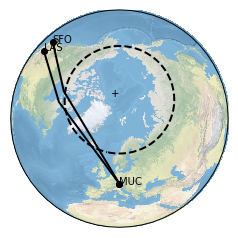

In [14]:
ax = plt.axes(projection=ccrs.NearsidePerspective(central_latitude=80.0,central_longitude=origin_lon))
ax.stock_img()


plt.text(0, 90, '+',
         horizontalalignment='right',
         transform=ccrs.Geodetic())


plt.plot(np.linspace(0,359,360), np.ones(360)*arctic_circle_lat,
         color='black', linewidth=2, ls='--',
         transform=ccrs.Geodetic(),
         )

plt.text(origin_lon, origin_lat, origin, transform=ccrs.Geodetic())


for i in range(len(dest_airports)):
    if does_this_route_pass_through_arctic[i]:
        plt.plot([origin_lon,np.float(dest_airports.loc[i].lon)],
                 [origin_lat,np.float(dest_airports.loc[i].lat)],
                color='black',linewidth=2,marker='o',
                transform=ccrs.Geodetic())
        plt.text(np.float(dest_airports.loc[i].lon),np.float(dest_airports.loc[i].lat),
                dest_airports.loc[i].code,transform=ccrs.Geodetic())
        


    


plt.savefig(origin+'-arctic_routes.pdf',fmt='pdf')

In [16]:
print("Routes from "+origin+that pass near the Arctic")
print("--------------------------------")
for i in range(len(does_this_route_pass_through_arctic)):
    if does_this_route_pass_through_arctic[i]:
        print(origin+'-'+dest_airports.loc[i].code)



Routes that pass near the Arctic
--------------------------------
MUC-SFO
MUC-LAS
